In [1]:
from PyUoI.UoINMF import UoINMF
from activ import load_data, data_normalization
import os
from activ.readfile import TrackTBIFile
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
from activ.analytics import heatmap, nmf_bases_heatmap
from activ.clustering import UmapClusteringResults
from os.path import dirname, join
from scipy.optimize import curve_fit
from scipy.stats import norm, sem
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display, Latex, Markdown
from scipy.stats import norm, sem

/Users/ahyeon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/ahyeon/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def conf_alliter(size, predicted, actual):
    confalliter = []
    for j in range(50):
        conf = np.zeros((size,size))
        labs = list(map(int, actual[j][size-2]))
        preds = list(map(int, predicted[j][size-2]))
        for l, p in zip(labs, preds):
            conf[l,p] += 1
        confalliter.append(conf)
    return confalliter

In [4]:
def statistics(matrix):
    mat = np.matrix(matrix)
    i = mat.shape[0]-2
    tp = mat[i,i]
    tn = mat.sum() - mat[i,:].sum() - mat[:,i].sum() + mat[i,i]
    fp = mat[:,i].sum() - mat[i,i]
    fn = mat[i,:].sum() - mat[i,i]
    return tp, tn, fp, fn

In [3]:
def accuracy(mat):
    return mat.trace()/mat.sum()

def specificity(tn, fp):
    return tn/(tn+fp)

def sensitivity(tp, fn):
    return tp/(tp+fn)

def fscore(tp, fp, fn):
    return (2*tp)/(2*tp+fp+fn)

No handles with labels found to put in legend.


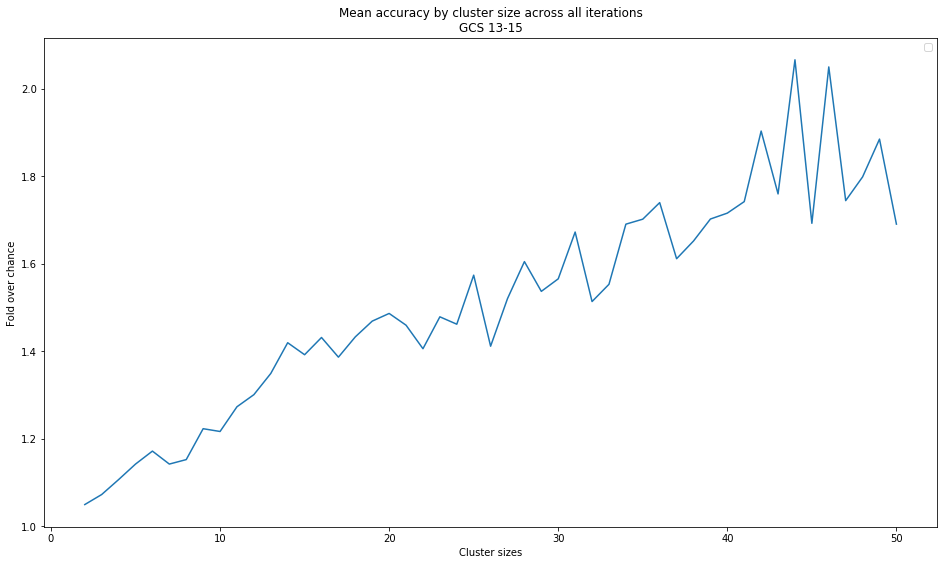

In [16]:
path = '/Users/ahyeon/Desktop/activ/results/gcs13-15/dim_10_gcs13-15_results.h5'
f = h5py.File(path, 'r')
predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 50))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
fold_over_chance = np.mean(fold_over_chance, axis=1)

plt.rcParams["figure.figsize"] = [16,9]
cmap = plt.get_cmap("tab10")
plt.plot(cluster_sizes, fold_over_chance)

plt.title("Mean accuracy by cluster size across all iterations\nGCS 13-15")
plt.xlabel("Cluster sizes")
plt.ylabel("Fold over chance")
plt.legend()
plt.savefig('/Users/ahyeon/Desktop/activ misc/gcs13-15.pdf')

/Users/ahyeon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


(50, 49, 210)


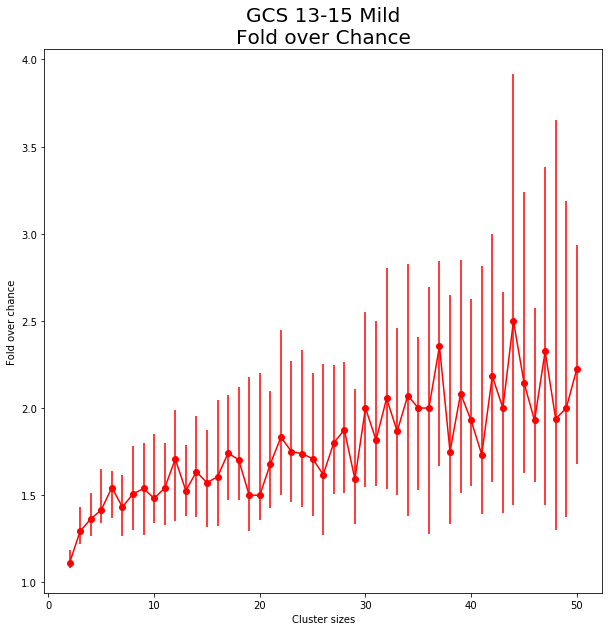

In [8]:
path = '/Users/ahyeon/Desktop/activ misc/gcs13-15_umap_results.h5'
f = h5py.File(path, 'r')
predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 50))
raw_acc = np.zeros((len(cluster_sizes), 50))
normalized_acc = np.zeros((len(cluster_sizes), 50))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
    raw_acc[jj,:] = acc
    normalized_acc[jj,:] = norm_acc
print(predictions.shape)

plt.rcParams["figure.figsize"] = [10,10]
cmap = plt.get_cmap("tab10")
lower = np.asarray([np.percentile(fold_over_chance[i,:], 25) for i in range(49)])
upper = np.asarray([np.percentile(fold_over_chance[i,:], 75) for i in range(49)])
med = np.median(fold_over_chance, axis=1)
raw_med = np.median(raw_acc, axis=1)
raw_lower = [np.percentile(raw_acc[i,:], 25) for i in range(49)]
raw_upper = [np.percentile(raw_acc[i,:], 75) for i in range(49)]
norm_med = np.median(normalized_acc, axis=1)
norm_lower = [np.percentile(normalized_acc[i,:], 25) for i in range(49)]
norm_upper = [np.percentile(normalized_acc[i,:], 75) for i in range(49)]
yerr = upper-lower
rel_iqr = yerr/med

plt.errorbar(cluster_sizes, med, yerr=[med-lower,upper-med], color = 'red',fmt='-o', label='Fold over chance')
# plt.errorbar(cluster_sizes, raw_med, yerr=[raw_med-raw_lower,raw_upper-raw_med], color='black',fmt='-o', label='Raw accuracy')
# plt.errorbar(cluster_sizes, norm_med, yerr=[norm_med-norm_lower, norm_upper-norm_med], color='grey',fmt='-o', label='Chance accuracy')


plt.title("GCS 13-15 Mild\nFold over Chance", fontsize=20)
plt.xlabel("Cluster sizes")
plt.ylabel("Fold over chance")

plt.savefig('/Users/ahyeon/Desktop/activ misc/gcs13-15_foc.pdf')

(50, 49, 13) (49, 50)


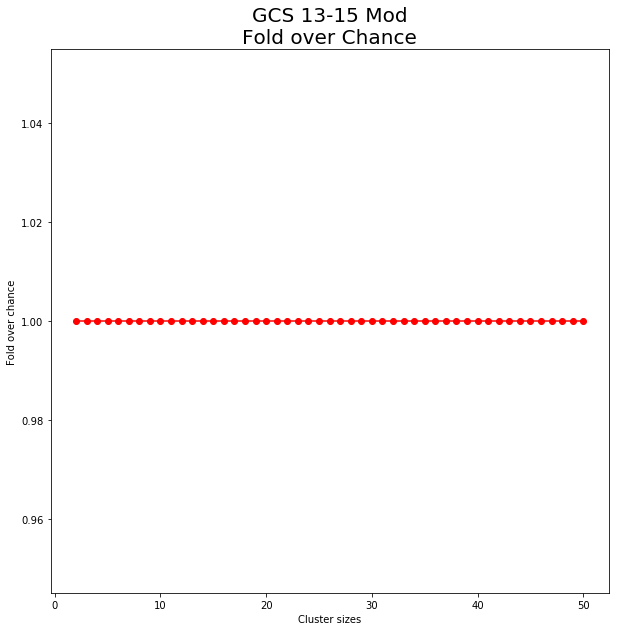

In [9]:
path = '/Users/ahyeon/Desktop/activ misc/gcs_mod_results.h5'
f = h5py.File(path, 'r')
predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 50))
raw_acc = np.zeros((len(cluster_sizes), 50))
normalized_acc = np.zeros((len(cluster_sizes), 50))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
    raw_acc[jj,:] = acc
    normalized_acc[jj,:] = norm_acc

print(predictions.shape, fold_over_chance.shape)
plt.rcParams["figure.figsize"] = [10,10]
cmap = plt.get_cmap("tab10")
lower = np.asarray([np.percentile(fold_over_chance[i,:], 25) for i in range(49)])
upper = np.asarray([np.percentile(fold_over_chance[i,:], 75) for i in range(49)])
med = np.mean(fold_over_chance, axis=1)
raw_med = np.median(raw_acc, axis=1)
raw_lower = [np.percentile(raw_acc[i,:], 25) for i in range(49)]
raw_upper = [np.percentile(raw_acc[i,:], 75) for i in range(49)]
norm_med = np.median(normalized_acc, axis=1)
norm_lower = [np.percentile(normalized_acc[i,:], 25) for i in range(49)]
norm_upper = [np.percentile(normalized_acc[i,:], 75) for i in range(49)]
yerr = upper-lower
rel_iqr = yerr/med

plt.errorbar(cluster_sizes, med, yerr=[med-lower,upper-med], color = 'red',fmt='-o', label='Fold over chance')
# plt.errorbar(cluster_sizes, raw_med, yerr=[raw_med-raw_lower,raw_upper-raw_med], color='black',fmt='-o', label='Raw accuracy')
# plt.errorbar(cluster_sizes, norm_med, yerr=[norm_med-norm_lower, norm_upper-norm_med], color='grey',fmt='-o', label='Chance accuracy')


plt.title("GCS 9-12 Mod\nFold over Chance", fontsize=20)
plt.xlabel("Cluster sizes")
plt.ylabel("Fold over chance")

plt.savefig('/Users/ahyeon/Desktop/activ misc/gcs_mod_foc.pdf')

(50, 49, 24)


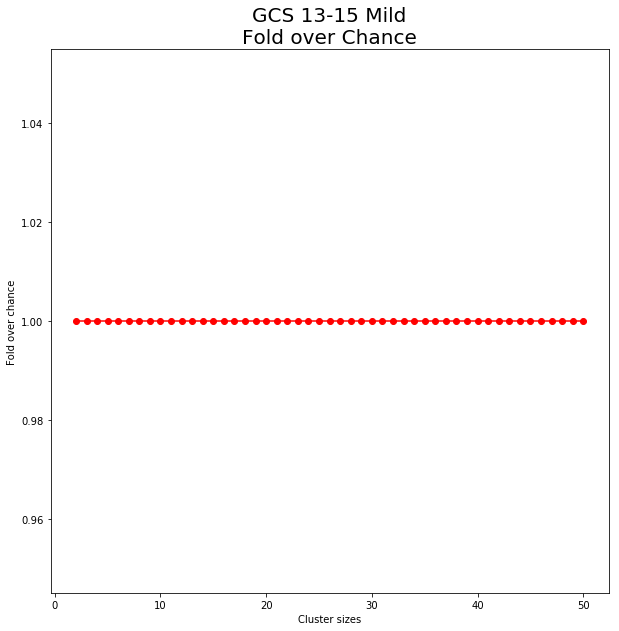

In [7]:
path = '/Users/ahyeon/Desktop/activ misc/gcs_sev_results.h5'
f = h5py.File(path, 'r')
predictions = np.squeeze(f['score'][:], axis=1)
norm_predictions = np.squeeze(f['norm_score'][:], axis=1)
cluster_sizes = f['cluster_sizes'][:]
labels = np.squeeze(f['clusters'][:], axis=1)
fold_over_chance = np.zeros((len(cluster_sizes), 50))
raw_acc = np.zeros((len(cluster_sizes), 50))
normalized_acc = np.zeros((len(cluster_sizes), 50))
for jj,c in enumerate(cluster_sizes):
    all50mat = conf_alliter(c, predictions, labels)
    norm_all50mat = conf_alliter(c, norm_predictions, labels)
    acc = [accuracy(i) for i in all50mat]
    norm_acc = [accuracy(i) for i in norm_all50mat]
    foc = [float(x/y) for x, y in zip(acc, norm_acc)]
    fold_over_chance[jj,:] = foc
    raw_acc[jj,:] = acc
    normalized_acc[jj,:] = norm_acc
print(predictions.shape)

plt.rcParams["figure.figsize"] = [10,10]
cmap = plt.get_cmap("tab10")
lower = np.asarray([np.percentile(fold_over_chance[i,:], 25) for i in range(49)])
upper = np.asarray([np.percentile(fold_over_chance[i,:], 75) for i in range(49)])
med = np.median(fold_over_chance, axis=1)
raw_med = np.median(raw_acc, axis=1)
raw_lower = [np.percentile(raw_acc[i,:], 25) for i in range(49)]
raw_upper = [np.percentile(raw_acc[i,:], 75) for i in range(49)]
norm_med = np.median(normalized_acc, axis=1)
norm_lower = [np.percentile(normalized_acc[i,:], 25) for i in range(49)]
norm_upper = [np.percentile(normalized_acc[i,:], 75) for i in range(49)]
yerr = upper-lower
rel_iqr = yerr/med

plt.errorbar(cluster_sizes, med, yerr=[med-lower,upper-med], color = 'red',fmt='-o', label='Fold over chance')
# plt.errorbar(cluster_sizes, raw_med, yerr=[raw_med-raw_lower,raw_upper-raw_med], color='black',fmt='-o', label='Raw accuracy')
# plt.errorbar(cluster_sizes, norm_med, yerr=[norm_med-norm_lower, norm_upper-norm_med], color='grey',fmt='-o', label='Chance accuracy')


plt.title("GCS <=8 Sev\nFold over Chance", fontsize=20)
plt.xlabel("Cluster sizes")
plt.ylabel("Fold over chance")

plt.savefig('/Users/ahyeon/Desktop/activ misc/gcs_sev_foc.pdf')